In [1]:
# from pathlib import Path
# import sys
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import models, datasets, transforms
# from torchvision.datasets import ImageFolder
# from torch.utils.data import DataLoader
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix
# import ray
# from ray import tune
# from ray.train import get_context
# import pickle
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Add project root to sys.path if it does not exist
# project_root = Path().resolve().parents[0]
# if str(project_root) not in sys.path:
#     sys.path.insert(0, str(project_root))

# # from utils.utils import create_logger
# from src.data.custom_dataset import CustomDataset

In [2]:
# colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# colab
!pip install seaborn scikit-learn ray[tune]
!pip install light-the-torch >> /.tmp
!ltt install torch torchvision >> /.tmp
!pip install fastai --upgrade >> /.tmp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 MB 31.2 MB/s eta 0:00:00


In [4]:
# colab
from pathlib import Path
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import ray
from ray import tune
from ray.train import get_context
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [5]:
# colab
project_root = Path("/content/drive/MyDrive/car-classification-api")

# Add project root to sys.path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [6]:
# colab
from src.data.custom_dataset import CustomDataset

In [7]:
train_dir = project_root / "data" / "train"

In [8]:
train_data = ImageFolder(root=str(train_dir))
class_mapping = {idx: class_name for idx, class_name in enumerate(train_data.classes)}

print(class_mapping)

{0: 'AM General Hummer SUV 2000', 1: 'Acura Integra Type R 2001', 2: 'Acura RL Sedan 2012', 3: 'Acura TL Sedan 2012', 4: 'Acura TL Type-S 2008', 5: 'Acura TSX Sedan 2012', 6: 'Acura ZDX Hatchback 2012', 7: 'Aston Martin V8 Vantage Convertible 2012', 8: 'Aston Martin V8 Vantage Coupe 2012', 9: 'Aston Martin Virage Convertible 2012', 10: 'Aston Martin Virage Coupe 2012', 11: 'Audi 100 Sedan 1994', 12: 'Audi 100 Wagon 1994', 13: 'Audi A5 Coupe 2012', 14: 'Audi R8 Coupe 2012', 15: 'Audi RS 4 Convertible 2008', 16: 'Audi S4 Sedan 2007', 17: 'Audi S4 Sedan 2012', 18: 'Audi S5 Convertible 2012', 19: 'Audi S5 Coupe 2012', 20: 'Audi S6 Sedan 2011', 21: 'Audi TT Hatchback 2011', 22: 'Audi TT RS Coupe 2012', 23: 'Audi TTS Coupe 2012', 24: 'Audi V8 Sedan 1994', 25: 'BMW 1 Series Convertible 2012', 26: 'BMW 1 Series Coupe 2012', 27: 'BMW 3 Series Sedan 2012', 28: 'BMW 3 Series Wagon 2012', 29: 'BMW 6 Series Convertible 2007', 30: 'BMW ActiveHybrid 5 Sedan 2012', 31: 'BMW M3 Coupe 2012', 32: 'BMW M5

In [9]:
# Define the directory using Path
ray_results_dir = project_root / "ray_results"

# Ensure the directory exists
ray_results_dir.mkdir(parents=True, exist_ok=True)

In [10]:
def train_resnet50(config):

    model = models.resnet50(weights='DEFAULT')

    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False

    # Get all bottleneck blocks in layer4
    bottleneck_blocks = list(model.layer4.children()) # there are 3 bottleneck blocks

    # Select how many bottleneck blocks to unfreeze based on Ray Tune
    num_blocks_to_unfreeze = config["num_bottlenecks_to_unfreeze"]
    blocks_to_unfreeze = bottleneck_blocks[-num_blocks_to_unfreeze:]

    # Unfreeze all layers inside the selected bottleneck blocks
    for block in blocks_to_unfreeze:
        for param in block.parameters():
            param.requires_grad = True

    # # Always keep BatchNorm layers trainable
    # for module in model.modules():
    #     if isinstance(module, nn.BatchNorm2d):
    #         for param in module.parameters():
    #             param.requires_grad = True

    # Modify the classifier
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, config["num_classes"])

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    print(f"Using device: {device}")  # Check if GPU is being used

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config["lr"]
    )

    # Data transformations
    train_transformers = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transformers = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


    # Load datasets
    train_data = datasets.ImageFolder(train_dir)

    # Extract labels
    labels = [train_data.targets[idx] for idx in range(len(train_data))]

    # Stratified split
    train_indices, val_indices = train_test_split(
        range(len(train_data)),
        test_size=0.2,
        stratify=labels,
        random_state=42
)

    # Split into train and validation datasets
    train_dataset = CustomDataset(train_data, train_indices, transform=train_transformers)
    val_dataset = CustomDataset(train_data, val_indices, transform=val_transformers)

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=2, pin_memory=True)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')

    # Get the TrainContext from Ray Tune
    context = get_context()

    # Access trial-specific metadata
    trial_id = context.get_trial_id() # Unique trial ID
    trial_name = context.get_trial_name()  # Human-readable trial name
    trial_dir = Path(context.get_trial_dir())  # Directory for trial-specific files

    # Training loop
    for epoch in range(config["epochs"]):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Predictions for training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Predictions for val accuracy
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Save checkpoint only if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss

            # Choose data to save as part of checkpoint
            checkpoint_data = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_loss": val_loss,
                "config": config
            }

            # Create a unique checkpoint dir
            checkpoint_dir = trial_dir / f"checkpoint_epoch_{epoch}"
            checkpoint_dir.mkdir(parents=True, exist_ok=True)

            # Save checkpoint data to the subdirectory
            checkpoint_path = checkpoint_dir / f"checkpoint_epoch_{epoch}.pkl"
            with open(checkpoint_path, "wb") as fp:
                pickle.dump(checkpoint_data, fp)


        ray.tune.report({"train_loss": train_loss,
                        "train_accuracy": train_accuracy,
                        "val_loss": val_loss,
                        "val_accuracy": val_accuracy,
                        "train_losses": train_losses,
                        "val_losses": val_losses,
                        "val_accuracies": val_accuracies,
                        "train_accuracies": train_accuracies})

In [ ]:
# ray.shutdown()  # Shut down Ray

In [11]:
ray.init(runtime_env={
    "working_dir": "/content/drive/MyDrive/car-classification-api"
    })

2025-02-04 07:52:26,950	INFO worker.py:1841 -- Started a local Ray instance.
2025-02-04 07:53:20,903	INFO packaging.py:574 -- Creating a file package for local module '/content/drive/MyDrive/car-classification-api'.
2025-02-04 07:53:20,968	WARNING packaging.py:416 -- File /content/drive/MyDrive/car-classification-api/.git/objects/pack/pack-f831df544f72af764e9750c0aa54b873f27bb300.pack is very large (17.75MiB). Consider adding this file to the 'excludes' list to skip uploading it: `ray.init(..., runtime_env={'excludes': ['/content/drive/MyDrive/car-classification-api/.git/objects/pack/pack-f831df544f72af764e9750c0aa54b873f27bb300.pack']})`
2025-02-04 07:53:21,229	INFO packaging.py:366 -- Pushing file package 'gcs://_ray_pkg_6355813df41ef023.zip' (32.17MiB) to Ray cluster...
2025-02-04 07:53:21,375	INFO packaging.py:379 -- Successfully pushed file package 'gcs://_ray_pkg_6355813df41ef023.zip'.


Python version:,3.11.11
Ray version:,2.42.0


In [12]:
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")
print("Memory Allocated:", torch.cuda.memory_allocated(0) / 1024**2, "MB")
print("Memory Cached:", torch.cuda.memory_reserved(0) / 1024**2, "MB")

CUDA Available: True
GPU Name: Tesla T4
Memory Allocated: 0.0 MB
Memory Cached: 0.0 MB


In [14]:
# Hyperparameter tuning

search_space = {
    "lr": tune.loguniform(1e-4, 1e-2),  # Learning rate
    "batch_size": tune.choice([16, 32, 64, 128]),  # Batch size
    "num_bottlenecks_to_unfreeze": tune.choice([1, 2, 3]),  # Number of bottlenecks in layer 4 to unfreeze
    "num_classes": len(datasets.ImageFolder(train_dir).classes),  # Number of classes
    "epochs": 20  # Number of epochs
}

tuner = tune.Tuner(
    tune.with_resources(train_resnet50, resources={"gpu": 1, "cpu": 8}),
    param_space=search_space,
    tune_config=tune.TuneConfig(
        metric="val_accuracy",
        mode="max", # Optimize for maximum val accuracy
        num_samples=8, # Limit to 8 trials of random combinations of hyperparameters fr search_space
        max_concurrent_trials=1 # Run 1 trial at a time
        )
        ,
    run_config=tune.RunConfig(storage_path=str(ray_results_dir))
)

results = tuner.fit()

+-----------------------------------------------------------------------+
| Configuration for experiment     train_resnet50_2025-02-04_07-54-53   |
+-----------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                |
| Scheduler                        FIFOScheduler                        |
| Number of trials                 8                                    |
+-----------------------------------------------------------------------+

View detailed results here: /content/drive/MyDrive/car-classification-api/ray_results/train_resnet50_2025-02-04_07-54-53
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-02-04_07-52-25_192477_627/artifacts/2025-02-04_07-54-53/train_resnet50_2025-02-04_07-54-53/driver_artifacts`

Trial status: 1 PENDING
Current time: 2025-02-04 07:54:53. Total running time: 0s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4

2025-02-04 08:10:06,822	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-02-04 08:10:06,844	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/drive/MyDrive/car-classification-api/ray_results/train_resnet50_2025-02-04_07-54-53' in 0.0206s.


Trial status: 1 RUNNING
Current time: 2025-02-04 08:10:06. Total running time: 15min 13s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------+
| Trial name                   status              lr     batch_size     ...necks_to_unfreeze |
+---------------------------------------------------------------------------------------------+
| train_resnet50_51980_00000   RUNNING    0.000287719             16                        1 |
+---------------------------------------------------------------------------------------------+


2025-02-04 08:10:16,852	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="/content/drive/MyDrive/car-classification-api/ray_results/train_resnet50_2025-02-04_07-54-53", trainable=...)


In [ ]:
results

ResultGrid<[
  Result(
    metrics={'train_loss': 2.9477792721584533, 'train_accuracy': 27.152724481964697, 'val_loss': 2.4923831972421384, 'val_accuracy': 35.850214855739715, 'train_losses': [4.825356227488606, 3.651331896577145, 2.9477792721584533], 'val_losses': [3.9938175175704207, 3.0813682593551337, 2.4923831972421384], 'val_accuracies': [10.313075506445673, 24.12523020257827, 35.850214855739715], 'train_accuracies': [4.159631619339985, 14.842670759785111, 27.152724481964697]},
    path='/Users/jas/Documents/car-classification-api/ray_results/train_efficientnet_2025-01-28_21-41-40/train_efficientnet_9ad0c_00000_0_batch_size=8,lr=0.0041,num_layers_to_unfreeze=2_2025-01-28_21-41-40',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'train_loss': 1.6309992803954612, 'train_accuracy': 61.58096699923254, 'val_loss': 1.2340325584598617, 'val_accuracy': 67.03499079189687, 'train_losses': [4.720516790946324, 2.7607828469253053, 1.6309992803954612], 'val_losses': [3

In [ ]:
for result in results:
    print(f"Trial Config: {result.config}, Validation Loss: {result.metrics['val_loss']}, Validation Accuracy: {result.metrics['val_accuracy']}")

Trial Config: {'lr': 0.004062981313084053, 'batch_size': 8, 'num_layers_to_unfreeze': 2, 'num_classes': 196, 'epochs': 3}, Validation Loss: 2.4923831972421384, Validation Accuracy: 35.850214855739715
Trial Config: {'lr': 0.00022599127599793093, 'batch_size': 16, 'num_layers_to_unfreeze': 4, 'num_classes': 196, 'epochs': 3}, Validation Loss: 1.2340325584598617, Validation Accuracy: 67.03499079189687
Trial Config: {'lr': 0.00015095941275045726, 'batch_size': 8, 'num_layers_to_unfreeze': 3, 'num_classes': 196, 'epochs': 3}, Validation Loss: 1.7412748802818505, Validation Accuracy: 53.468385512584405
Trial Config: {'lr': 0.0010125966079180008, 'batch_size': 8, 'num_layers_to_unfreeze': 4, 'num_classes': 196, 'epochs': 3}, Validation Loss: 1.5939857881589263, Validation Accuracy: 55.80110497237569


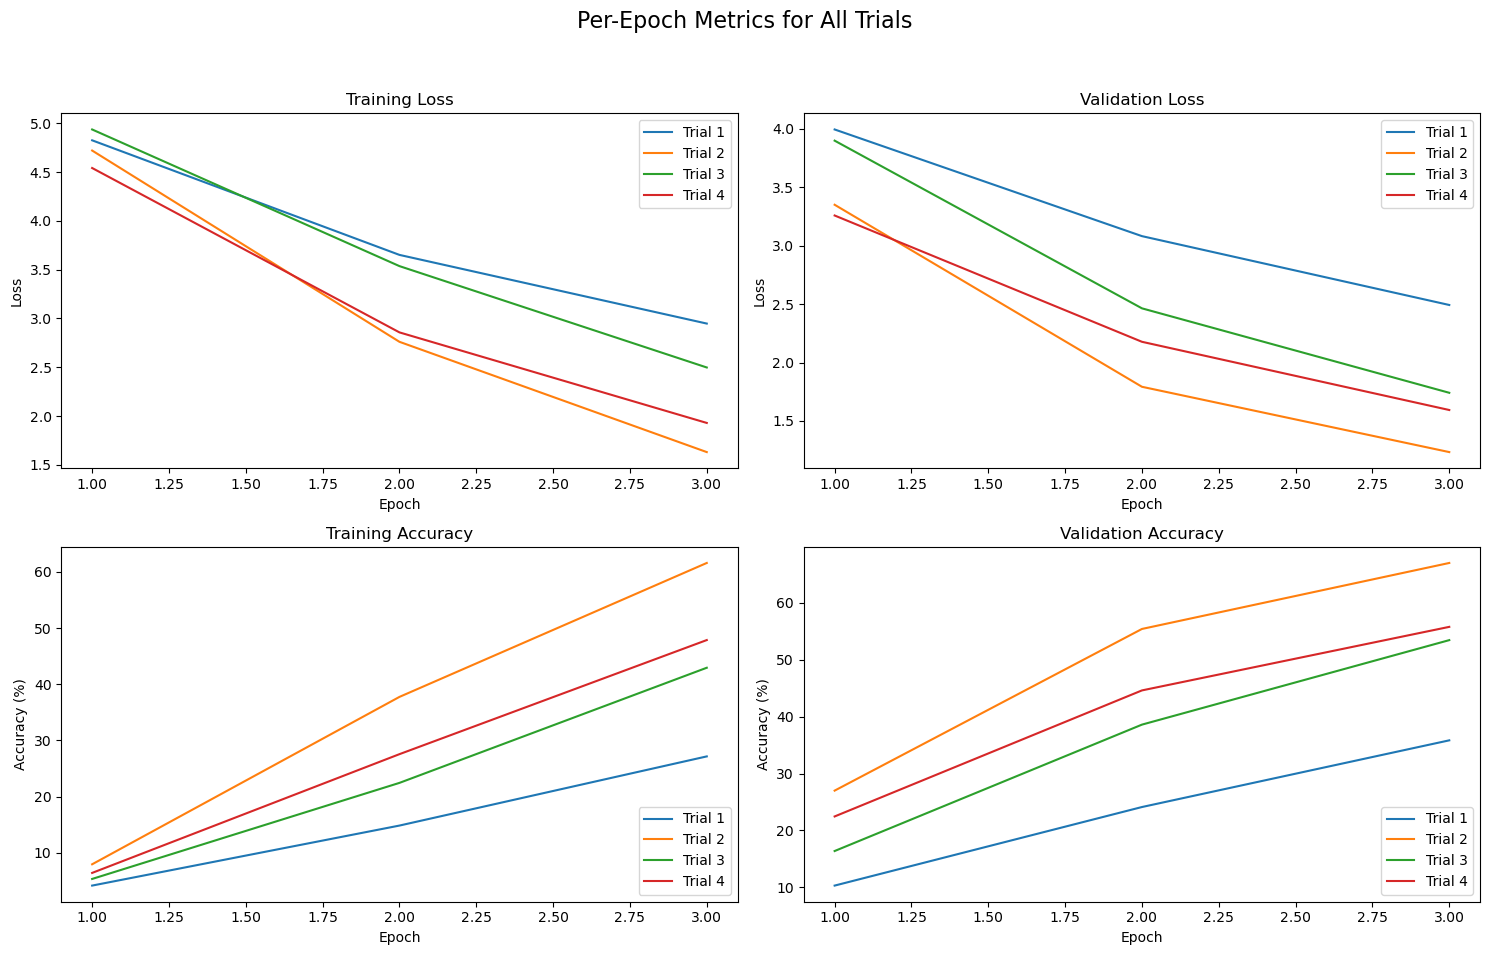

In [ ]:
# Initialize plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Per-Epoch Metrics for All Trials", fontsize=16)

# Colors for distinguishing trials
colors = plt.cm.tab10.colors

# Iterate through results and plot metrics
for i, result in enumerate(results):
    metrics = result.metrics
    train_losses = metrics.get("train_losses", [])
    val_losses = metrics.get("val_losses", [])
    train_accuracies = metrics.get("train_accuracies", [])
    val_accuracies = metrics.get("val_accuracies", [])

    # Plot training losses (top-left)
    axes[0, 0].plot(range(1, len(train_losses) + 1), train_losses, label=f'Trial {i+1}', color=colors[i % len(colors)])
    axes[0, 0].set_title("Training Loss")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")

    # Plot validation losses (top-right)
    axes[0, 1].plot(range(1, len(val_losses) + 1), val_losses, label=f'Trial {i+1}', color=colors[i % len(colors)])
    axes[0, 1].set_title("Validation Loss")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel("Loss")

    # Plot training accuracy (bottom-left)
    # if isinstance(train_accuracies, list):  # Check if accuracy is per epoch
    axes[1, 0].plot(range(1, len(train_accuracies) + 1), train_accuracies, label=f'Trial {i+1}', color=colors[i % len(colors)])
    axes[1, 0].set_title("Training Accuracy")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel("Accuracy (%)")

    # Plot validation accuracy (bottom-right)
    # if isinstance(val_accuracies, list):  # Check if accuracy is per epoch
    axes[1, 1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label=f'Trial {i+1}', color=colors[i % len(colors)])
    axes[1, 1].set_title("Validation Accuracy")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel("Accuracy (%)")

# Add legends
axes[0, 0].legend(loc="upper right")
axes[0, 1].legend(loc="upper right")
axes[1, 0].legend(loc="lower right")
axes[1, 1].legend(loc="lower right")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
def load_best_model(ray_results_dir):
    """
    Load the best restnet50 model based on validation loss from Ray Tune results.

    Args:
        ray_results_dir (str or Path): Path to the Ray results directory.

    Returns:
        torch.nn.Module: The model loaded with the best checkpoint.
        dict: The configuration of the best trial.
    """
    ray_results_dir = Path(ray_results_dir)
    best_val_loss = float('inf')
    best_checkpoint_file = None
    best_config = None

    # Traverse experiments
    for experiment_dir in ray_results_dir.iterdir():
        if not experiment_dir.is_dir():
            continue  # Skip non-directory files like tuner.pkl

        # Traverse trials within each experiment
        for trial_dir in experiment_dir.iterdir():
            if not trial_dir.is_dir():
                continue  # Skip non-directory files

            # Traverse checkpoints within each trial
            for checkpoint_dir in trial_dir.glob("checkpoint_epoch_*"):
                if not checkpoint_dir.is_dir():
                    continue  # Skip non-directory files

                checkpoint_file = checkpoint_dir / f"{checkpoint_dir.name}.pkl"
                if not checkpoint_file.exists():
                    continue  # Skip if the checkpoint file doesn't exist

                # Load checkpoint data
                with open(checkpoint_file, "rb") as fp:
                    checkpoint_data = pickle.load(fp)

                # Check for val_loss
                if "val_loss" not in checkpoint_data:
                    print(f"Skipping {checkpoint_file}: 'val_loss' not found")
                    continue

                val_loss = checkpoint_data["val_loss"]
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_checkpoint_file = checkpoint_file
                    best_config = checkpoint_data["config"]

    if best_checkpoint_file is None:
        raise ValueError("No valid checkpoint with 'val_loss' found.")

    # Load the best checkpoint data
    with open(best_checkpoint_file, "rb") as fp:
        best_checkpoint_data = pickle.load(fp)

    # Initialize the EfficientNet-B0 model
    model = models.resnet50(weights='DEFAULT')
    model.fc = torch.nn.Linear(
        best_checkpoint_data["model_state_dict"]["fc.weight"].size(1),
        best_config["num_classes"]
    )
    model.load_state_dict(best_checkpoint_data["model_state_dict"])
    model.eval()  # Set the model to evaluation mode

    return model, best_config


In [ ]:
# Load the best model
best_model, best_config = load_best_model(ray_results_dir)

In [ ]:
# Use the model for inference
print("Best model loaded with config:", best_config)

Best model loaded with config: {'lr': 0.00022599127599793093, 'batch_size': 16, 'num_layers_to_unfreeze': 4, 'num_classes': 196, 'epochs': 3}


In [ ]:
best_model.type

<bound method Module.type of EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
   

In [ ]:
# Move model to device
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

mps


In [ ]:
best_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
test_dir = project_root / "data" / "test"

In [ ]:
test_transformers = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_data = datasets.ImageFolder(test_dir, transform=test_transformers)
test_loader = DataLoader(test_data, batch_size=best_config["batch_size"], shuffle=False, num_workers=4)

In [ ]:
y_true, y_pred = [], []

best_model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

# Define criterion for loss computation (e.g., CrossEntropyLoss)
criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)

        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        loss = criterion(outputs, labels)
        test_loss += loss.item()


# Calculate metrics
test_loss = test_loss / len(test_loader)
test_accuracy = correct_test / total_test * 100

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert to DataFrame for better readability
cm_df = pd.DataFrame(cm, index=test_data.classes, columns=test_data.classes)

Test Loss: 1.2496, Test Accuracy: 66.82%


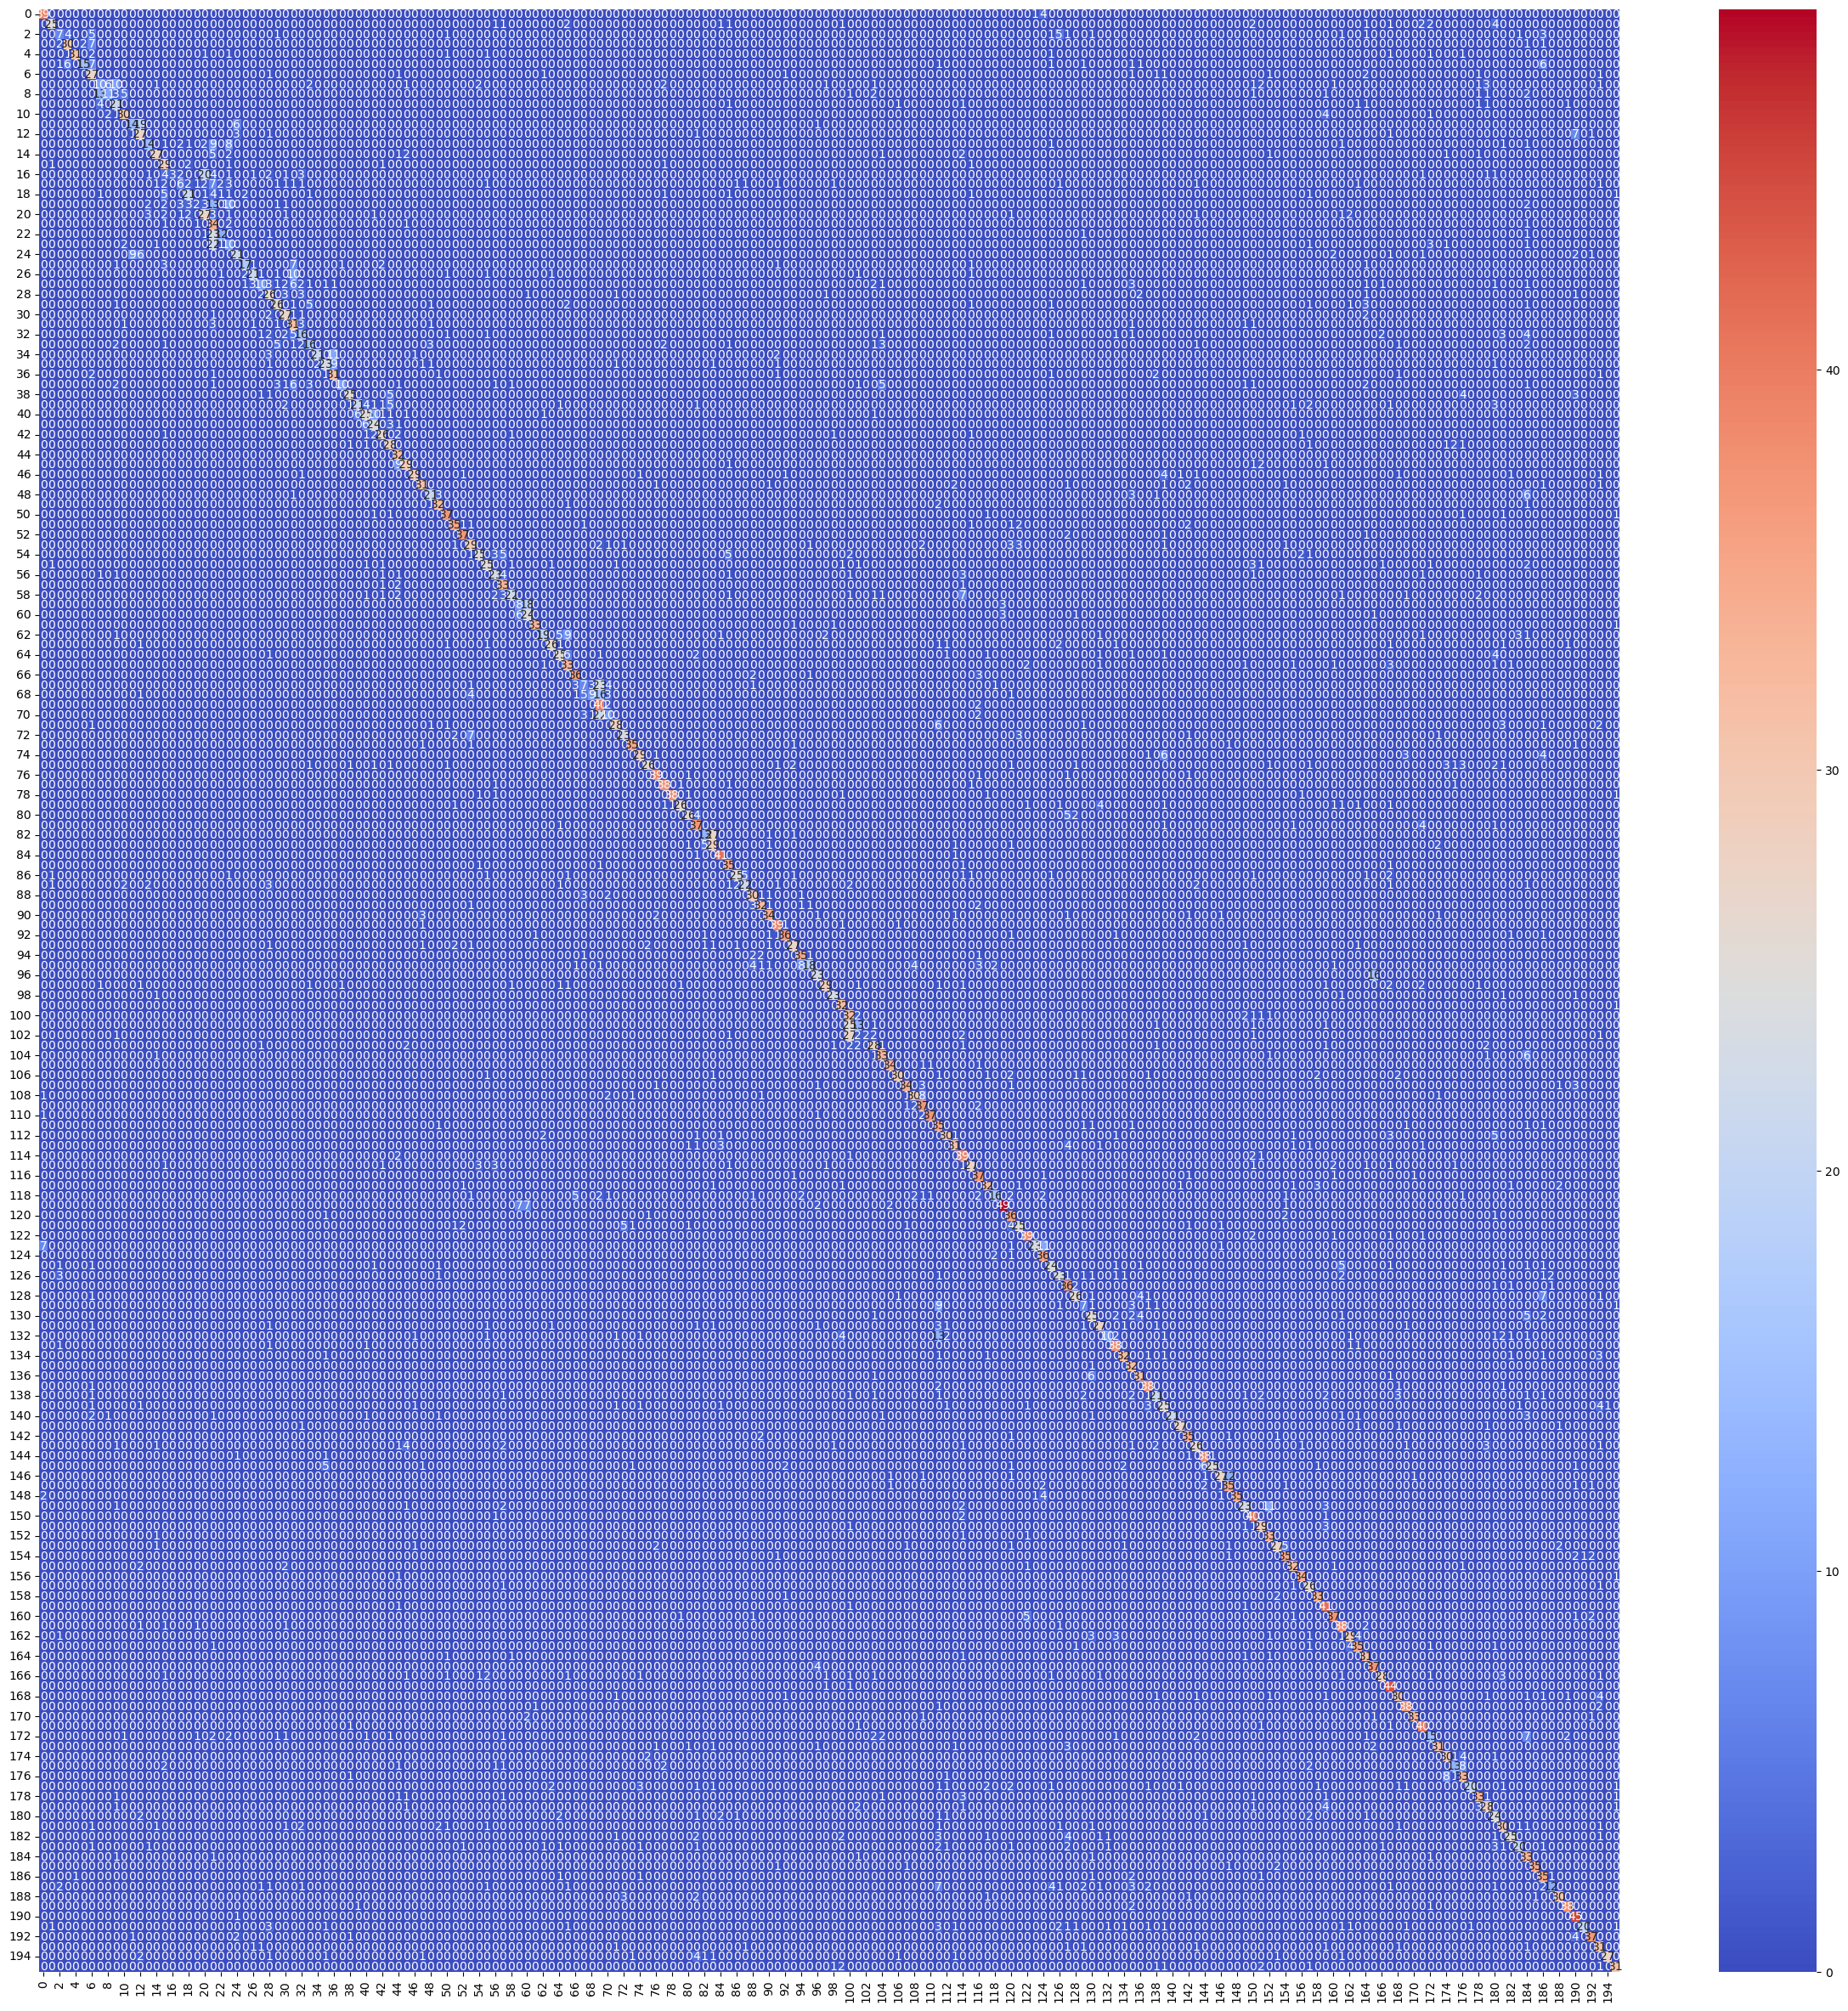

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm")  # Customize as needed
plt.show()

In [ ]:
# Flatten the confusion matrix DataFrame into a long format for filtering
cm_long = cm_df.reset_index().melt(id_vars='index', var_name='Predicted', value_name='Count')
cm_long = cm_long.rename(columns={'index': 'Actual'})

# Filter for misclassifications (Actual != Predicted) where the count is greater than 10
misclassified = cm_long[(cm_long['Actual'] != cm_long['Predicted']) & (cm_long['Count'] > 10)]

# Sort for better visibility
misclassified = misclassified.sort_values(by='Count', ascending=False)

# Display or save
print(misclassified)

                                              Actual  \
16350                       Dodge Caliber Wagon 2007   
19702            Ferrari California Convertible 2012   
19701                  Ferrari 458 Italia Coupe 2012   
4138                           Audi TT RS Coupe 2012   
13591     Chevrolet Silverado 1500 Extended Cab 2012   
4139                             Audi TTS Coupe 2012   
13594    Chevrolet Silverado 2500HD Regular Cab 2012   
3936                              Audi S4 Sedan 2007   
2363                             Audi 100 Sedan 1994   
11819               Chevrolet Express Cargo Van 2007   
13592  Chevrolet Silverado 1500 Hybrid Crew Cab 2012   
32436                  Dodge Sprinter Cargo Van 2009   
4135                              Audi S5 Coupe 2012   
21888         Hyundai Elantra Touring Hatchback 2012   
1380              Aston Martin V8 Vantage Coupe 2012   
28958                          Jeep Liberty SUV 2012   
7090                                 BMW X3 SUV 

In [ ]:
# FOR SAVING MODEL and class_mapping TO models folder

save_models_dir = project_root / "models"
save_models_dir.mkdir(parents=True, exist_ok=True)

model_file_name = save_models_dir/ "best_efficientnet_model.pth"
torch.save({"state_dict": best_model.state_dict(), "class_mapping": class_mapping}, str(model_file_name))

print(f"Model saved to {model_file_name}")

Model saved to /Users/jas/Documents/car-classification-api/models/best_efficientnet_model.pth


In [ ]:
class_mapping

{0: 'AM General Hummer SUV 2000',
 1: 'Acura Integra Type R 2001',
 2: 'Acura RL Sedan 2012',
 3: 'Acura TL Sedan 2012',
 4: 'Acura TL Type-S 2008',
 5: 'Acura TSX Sedan 2012',
 6: 'Acura ZDX Hatchback 2012',
 7: 'Aston Martin V8 Vantage Convertible 2012',
 8: 'Aston Martin V8 Vantage Coupe 2012',
 9: 'Aston Martin Virage Convertible 2012',
 10: 'Aston Martin Virage Coupe 2012',
 11: 'Audi 100 Sedan 1994',
 12: 'Audi 100 Wagon 1994',
 13: 'Audi A5 Coupe 2012',
 14: 'Audi R8 Coupe 2012',
 15: 'Audi RS 4 Convertible 2008',
 16: 'Audi S4 Sedan 2007',
 17: 'Audi S4 Sedan 2012',
 18: 'Audi S5 Convertible 2012',
 19: 'Audi S5 Coupe 2012',
 20: 'Audi S6 Sedan 2011',
 21: 'Audi TT Hatchback 2011',
 22: 'Audi TT RS Coupe 2012',
 23: 'Audi TTS Coupe 2012',
 24: 'Audi V8 Sedan 1994',
 25: 'BMW 1 Series Convertible 2012',
 26: 'BMW 1 Series Coupe 2012',
 27: 'BMW 3 Series Sedan 2012',
 28: 'BMW 3 Series Wagon 2012',
 29: 'BMW 6 Series Convertible 2007',
 30: 'BMW ActiveHybrid 5 Sedan 2012',
 31: '